In [40]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

# Veriyi yükle
data = pd.read_csv("retail_sales.csv")

# Gereksiz sütunları çıkar
data = data.drop(["Transaction ID", "Date", "Customer ID", "Total Amount"], axis=1)

# Kategorik değişkenleri işle
label_encoder = LabelEncoder()
data["Gender"] = label_encoder.fit_transform(data["Gender"])

# 'sparse' argümanı kaldırıldı, bunun yerine 'sparse_output' kullanın ve False olarak ayarlayın.
onehot_encoder = OneHotEncoder(sparse_output=False)  # 'sparse' yerine 'sparse_output' kullanın ve False olarak ayarlayın.
product_category_encoded = onehot_encoder.fit_transform(data[["Product Category"]])
product_category_df = pd.DataFrame(
    product_category_encoded,
    columns=onehot_encoder.get_feature_names_out(["Product Category"])
)

# Ana veri ile birleştir
data = pd.concat([data, product_category_df], axis=1)
data = data.drop("Product Category", axis=1)

# Eğitim ve test verisi ayır
X = data.drop("Quantity", axis=1)
y = data["Quantity"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
!pip install lightgbm  # LightGBM'i bilgisayarınıza kurun

In [46]:
!pip install --upgrade lightgbm

In [57]:
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.metrics import mean_squared_error
import numpy as np

# Veri setini yükleme ve ön işleme adımlarınız (X_train, X_test, y_train, y_test)

# LightGBM veri formatına çevirme
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Güncellenmiş hiperparametreler
params = {
    "objective": "regression",
    "metric": "rmse",
    "num_leaves": 63,
    "learning_rate": 0.01,
    "feature_fraction": 0.8,
    "min_data_in_leaf": 20,
    "verbose": -1
}

# Modeli eğit (daha uzun süre)
model = lgb.train(
    params,
    train_data,
    num_boost_round=5000,
    valid_sets=[test_data],
    callbacks=[early_stopping(stopping_rounds=100)]  # 100 iterasyon bekleyin
)

# Tahmin ve RMSE
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 1.14444
RMSE: 1.1444444393534594


In [58]:
print(data.isnull().sum())  # Eksik değer var mı kontrol edin

Gender                          0
Age                             0
Quantity                        0
Price per Unit                  0
Product Category_Beauty         0
Product Category_Clothing       0
Product Category_Electronics    0
dtype: int64


<Axes: ylabel='Quantity'>

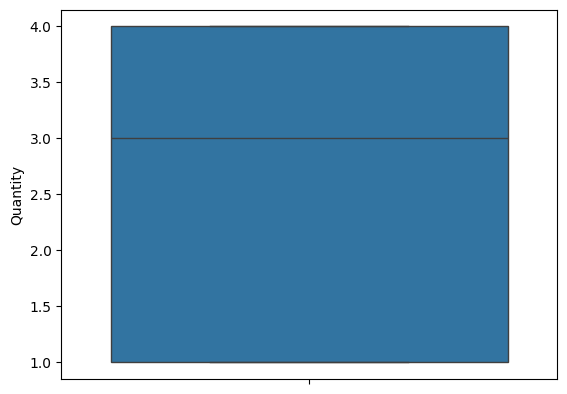

In [59]:
import seaborn as sns
sns.boxplot(data["Quantity"])  # Quantity sütununda aykırı değerleri görselleştirin

<Axes: >

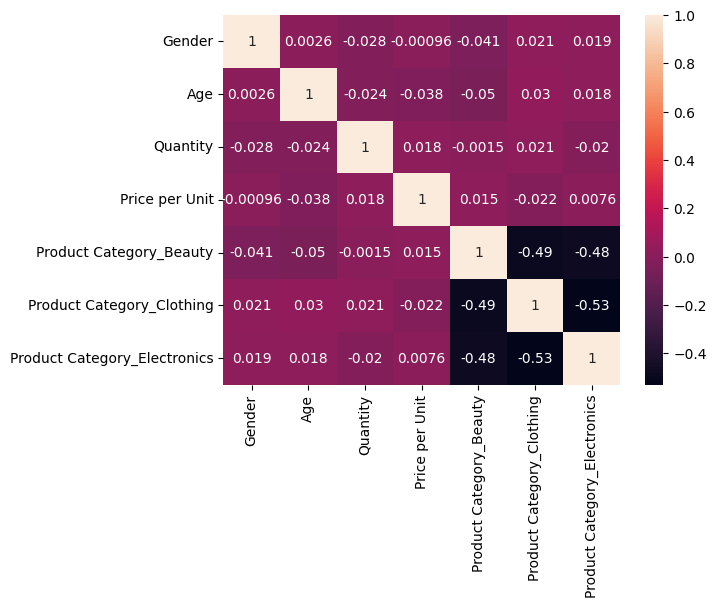

In [60]:
import seaborn as sns
sns.heatmap(data.corr(), annot=True)  # Özelliklerin Quantity ile korelasyonunu görün

<Axes: xlabel='Quantity', ylabel='Count'>

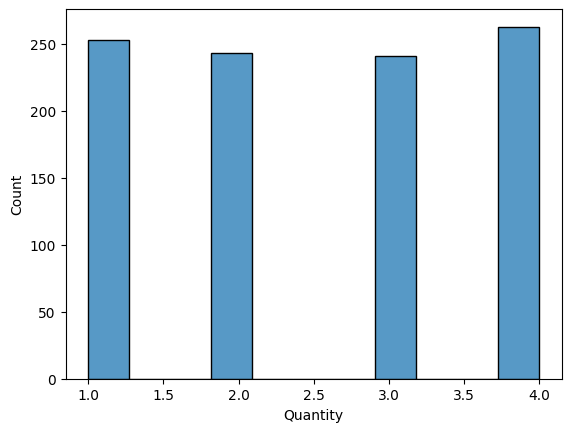

In [52]:
sns.histplot(data["Quantity"])  # Quantity'nin dağılımını kontrol edin

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

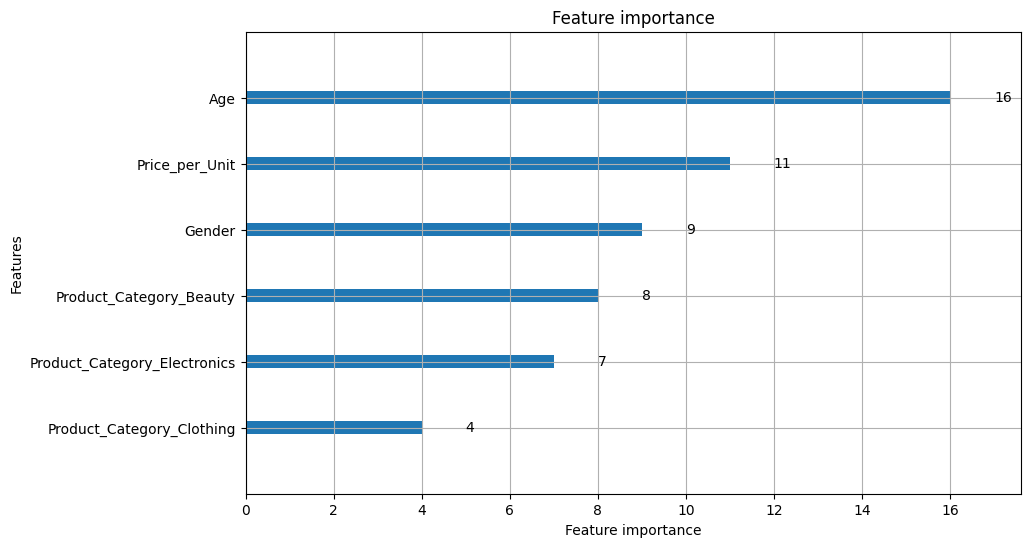

In [61]:
lgb.plot_importance(model, figsize=(10, 6))  # LightGBM özellik önemliliği

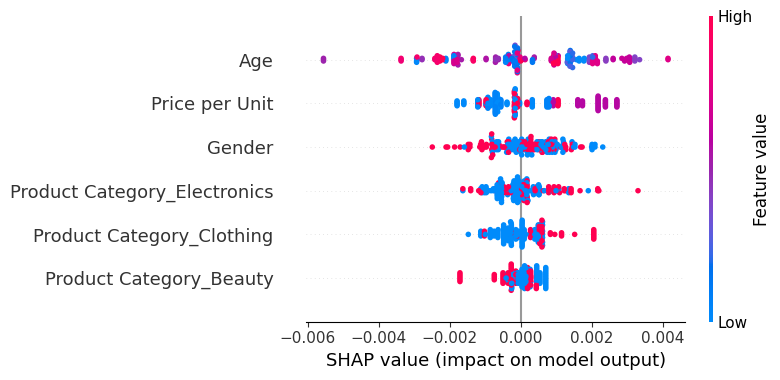

In [62]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)